Import all modules and necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import re

## Data pre processing

In [2]:
data = pd.read_csv("healthcare_reviews.csv") # Loading the data from csv file

In [3]:
data.head()

,Review_Text,Rating
0,I have mixed feelings about my experience.,4
1,The staff was caring and attentive. I couldn't...,5
2,I have mixed feelings about my experience.,5
3,I have mixed feelings about my experience.,5
4,The healthcare provider was excellent. I had a...,3


In [4]:
data.shape

(1000, 2)

In [5]:
data['Rating'].value_counts().sort_index()

Rating
1    189
2    209
3    168
4    223
5    211
Name: count, dtype: int64

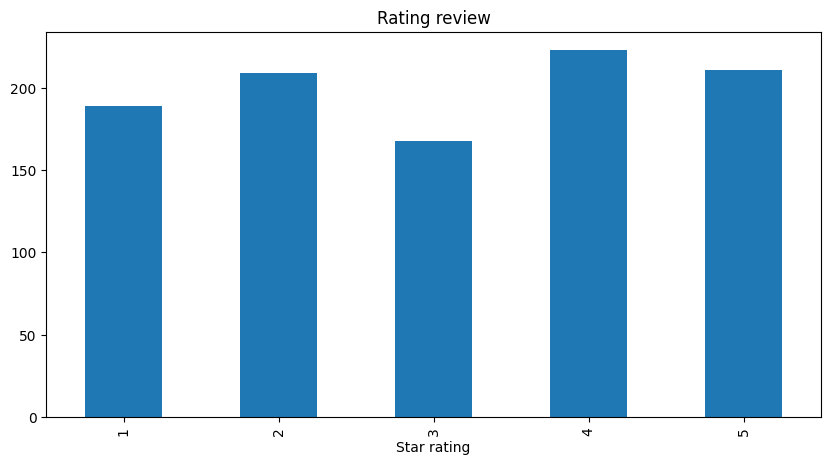

In [6]:
ax = data['Rating'].value_counts().sort_index() \
.plot(kind='bar',
      title = 'Rating review',
      figsize=(10,5))
ax.set_xlabel('Star rating')
plt.show()

In [7]:
data.isnull().sum()

Review_Text    100
Rating           0
dtype: int64

In [8]:
# No analysis can be done without review text, thus dropping all missing data.
data = data.dropna(subset=['Review_Text'])

In [9]:
data.isnull().sum() #Checking null values of both the columns

Review_Text    0
Rating         0
dtype: int64

In [10]:
# Building a target column
def map_sentiment(rating):
    if rating >= 4:
        return 'positive'
    elif rating == 3:
        return 'neutral'
    else:
        return 'negative'

data['sentiment'] = data['Rating'].apply(map_sentiment)

In [11]:
# Dropping the rating column as it is of no use no because we already have target column
data = data.drop(columns=['Rating'])

In [12]:
data.head() # Now we use supervised learning because we have a target column

,Review_Text,sentiment
0,I have mixed feelings about my experience.,positive
1,The staff was caring and attentive. I couldn't...,positive
2,I have mixed feelings about my experience.,positive
3,I have mixed feelings about my experience.,positive
4,The healthcare provider was excellent. I had a...,neutral


In [13]:
# Cleaning the review text

In [14]:
data['Review_Text'] = data['Review_Text'].str.split() # Already space separated so tokenized this way

In [15]:
data.head()

,Review_Text,sentiment
0,"[I, have, mixed, feelings, about, my, experien...",positive
1,"[The, staff, was, caring, and, attentive., I, ...",positive
2,"[I, have, mixed, feelings, about, my, experien...",positive
3,"[I, have, mixed, feelings, about, my, experien...",positive
4,"[The, healthcare, provider, was, excellent., I...",neutral


In [16]:
def clean_text(text):
    text = str(text).lower()                            # lowercase
    text = re.sub(r'\d+', '', text)                # remove numbers
    text = re.sub(r'[^\w\s]', '', text)            # remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()       # remove extra spaces
    return text

In [17]:
data['Review_Text'] = data['Review_Text'].apply(clean_text)

In [18]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english')) # get stopwords 

In [19]:
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

In [20]:
def remove_stopwords(text):
    #stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

In [ ]:
# Then apply it to my dataframe
data['Review_Text'] = data['Review_Text'].apply(remove_stopwords)

In [22]:
import pandas as pd
import spacy
# Performing lemmatization
nlp = spacy.load("en_core_web_sm")

def lemmatize_text_spacy(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

data['lemmatized_text'] = data['Review_Text'].apply(lemmatize_text_spacy)

In [23]:
data.head(10)

,Review_Text,sentiment,lemmatized_text
0,mixed feelings experience,positive,mixed feeling experience
1,staff caring attentive couldnt happier,positive,staff care attentive could not happy
2,mixed feelings experience,positive,mixed feeling experience
3,mixed feelings experience,positive,mixed feeling experience
4,healthcare provider excellent great experience,neutral,healthcare provider excellent great experience
5,staff caring attentive couldnt happier,positive,staff care attentive could not happy
7,bad experience healthcare provider avoid possible,negative,bad experience healthcare provider avoid possible
8,mixed feelings experience,neutral,mixed feeling experience
9,mixed feelings experience,positive,mixed feeling experience
10,service okay nothing exceptional,negative,service okay nothing exceptional


In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder, label_binarize
import joblib

In [ ]:
# 2. Encode target
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['sentiment'])  # Map to 0-negative, 1-neutral, 2-positive


In [26]:
X = data['lemmatized_text']
y = data['label']


In [27]:
# 3. Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


In [28]:
# 4. Build Pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
    ('nb', MultinomialNB())
])

In [29]:
# 5. Define hyperparameter grid
param_grid = {
    'tfidf__max_df': [0.9, 1.0],
    'tfidf__min_df': [1, 2],
    'nb__alpha': [0.1, 0.5, 1.0],
    'nb__fit_prior': [True, False]
}

In [ ]:
# 6. Grid Search with Cross-Validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(ngram_range=(1, 2))),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'nb__alpha': [0.1, 0.5, 1.0],
                         'nb__fit_prior': [True, False],
                         'tfidf__max_df': [0.9, 1.0], 'tfidf__min_df': [1, 2]},
             scoring='accuracy')

In [31]:
# 9. Save model and encoder
joblib.dump(grid_search.best_estimator_, 'naive_bayes_sentiment.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')

['label_encoder.pkl']

In [33]:
# 8. ROC AUC Score (macro-average for multiclass)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_score = grid_search.predict_proba(X_test)
roc_auc = roc_auc_score(y_test_bin, y_score, average='macro', multi_class='ovr')
print("Macro-average ROC AUC:", roc_auc)

Macro-average ROC AUC: 0.5019253261803823


In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle
import numpy as np

In [53]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

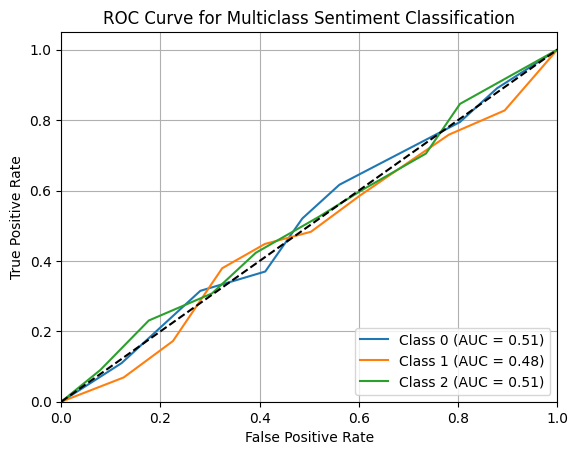

In [ ]:
# Plotting
plt.figure()
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Sentiment Classification')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, 
    precision_score, recall_score, f1_score, cohen_kappa_score, 
    log_loss
)

In [37]:
# Load the model and encoder
model = joblib.load('naive_bayes_sentiment.pkl')
encoder = joblib.load('label_encoder.pkl')

In [38]:
y_pred = model.predict(X_test)

In [39]:
# Predict class probabilities (only works if model supports it)
if hasattr(model, "predict_proba"):
    y_proba = model.predict_proba(X_test)
else:
    y_proba = None

In [40]:
# Assign true labels
y_true = y_test.values if hasattr(y_test, "values") else y_test

In [41]:
classes = ['negative', 'neutral', 'positive']

In [42]:
# 1. Classification Report
print("📊 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=classes))

📊 Classification Report:

              precision    recall  f1-score   support

    negative       0.42      0.52      0.47        73
     neutral       0.00      0.00      0.00        29
    positive       0.46      0.53      0.49        78

    accuracy                           0.44       180
   macro avg       0.29      0.35      0.32       180
weighted avg       0.37      0.44      0.40       180



c:\Users\saile\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\saile\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\saile\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

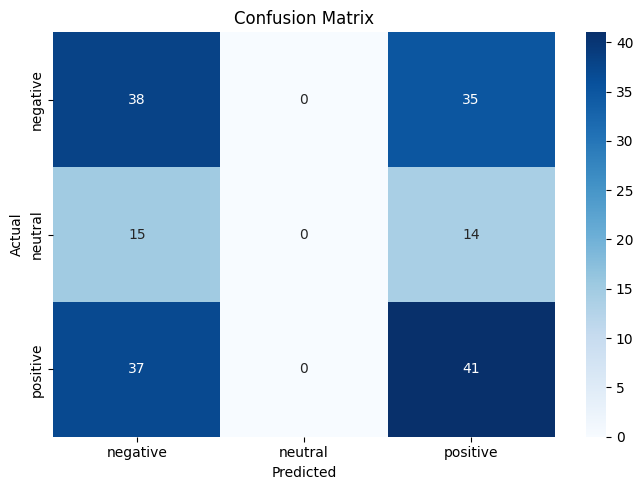

In [43]:
# 2. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

### Predict the new text

In [44]:
# Predict new text
new_texts = ["this is amazing", "not good", "okay product"]
pred_labels = model.predict(new_texts)
pred_classes = encoder.inverse_transform(pred_labels)


In [45]:
print("Predictions:", list(zip(new_texts, pred_classes)))

Predictions: [('this is amazing', 'positive'), ('not good', 'negative'), ('okay product', 'negative')]


### Since oversampling, applying SMOTE

In [55]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [56]:
# Sample input DataFrame: df['lemmatized_text'], df['sentiment']
# Encode target
le = LabelEncoder()
data['encoded_sentiment'] = le.fit_transform(data['sentiment'])  # e.g., [negative=0, neutral=1, positive=2]


In [57]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    data['lemmatized_text'], data['encoded_sentiment'], test_size=0.2, random_state=42, stratify=data['encoded_sentiment']
)

In [58]:
# Pipeline with SMOTE and GridSearchCV
pipeline = ImbPipeline([
    ('tfidf', TfidfVectorizer()),
    ('smote', SMOTE(random_state=42)),
    ('nb', MultinomialNB())
])

In [59]:
# Grid parameters to tune
param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__max_df': [0.9, 1.0],
    'tfidf__min_df': [1, 3],
    'nb__alpha': [0.5, 1.0, 1.5]
}

In [60]:
# GridSearchCV
grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_macro', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('smote', SMOTE(random_state=42)),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'nb__alpha': [0.5, 1.0, 1.5],
                         'tfidf__max_df': [0.9, 1.0], 'tfidf__min_df': [1, 3],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             scoring='f1_macro', verbose=1)

In [61]:
# Predictions
y_pred = grid.predict(X_test)

In [62]:
# Inverse transform to original labels if needed
y_test_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred)

In [63]:
# Evaluation
print("Best Params:\n", grid.best_params_)
print("\nClassification Report:\n", classification_report(y_test_labels, y_pred_labels))

Best Params:
 {'nb__alpha': 0.5, 'tfidf__max_df': 0.9, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 1)}

Classification Report:
               precision    recall  f1-score   support

    negative       0.42      0.52      0.47        73
     neutral       0.18      0.38      0.25        29
    positive       0.43      0.17      0.24        78

    accuracy                           0.34       180
   macro avg       0.35      0.36      0.32       180
weighted avg       0.39      0.34      0.33       180



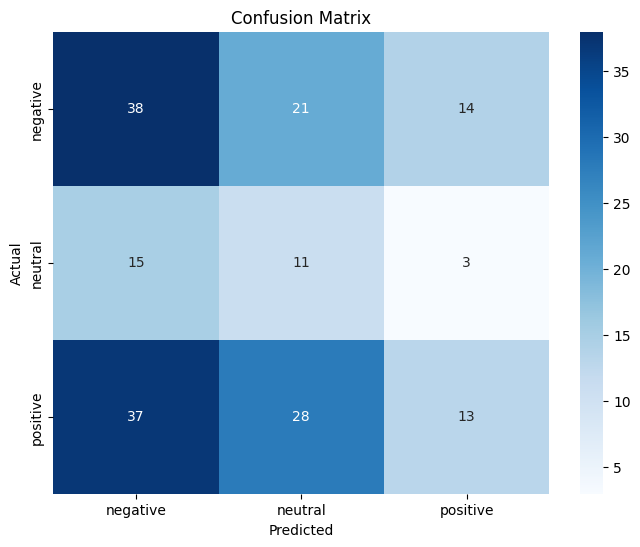

In [64]:
# Confusion Matrix
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=le.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [65]:
import joblib

# 🔮 Predict on test data
y_pred = grid.predict(X_test)
y_pred_labels = le.inverse_transform(y_pred)
y_test_labels = le.inverse_transform(y_test)

# ✅ Save the best model
joblib.dump(grid.best_estimator_, "sentiment_nb_pipeline.pkl")
print("✅ Model saved as 'sentiment_nb_pipeline.pkl'")

# ✅ Load the model (when needed)
# loaded_model = joblib.load("sentiment_nb_pipeline.pkl")



✅ Model saved as 'sentiment_nb_pipeline.pkl'


In [66]:
# Example new texts to predict
new_texts = [
    "I have mixed feelings, But is was okay!",
    "It was amazing",
    "Very disappointed with the experience."
]

# Load model
loaded_model = joblib.load("sentiment_nb_pipeline.pkl")

# Predict
new_preds_encoded = loaded_model.predict(new_texts)
new_preds = le.inverse_transform(new_preds_encoded)

# Show predictions
for text, label in zip(new_texts, new_preds):
    print(f"📝 Text: {text}\n🔮 Predicted Sentiment: {label}\n")


📝 Text: I have mixed feelings, But is was okay!
🔮 Predicted Sentiment: neutral

📝 Text: It was amazing
🔮 Predicted Sentiment: negative

📝 Text: Very disappointed with the experience.
🔮 Predicted Sentiment: neutral

